### In this project, the Sine wave is predicted by using standard RNN as well as LSTM (Long Short Term Memory)

# standard RNN

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
x = np.linspace(0,50,501)

In [43]:
y = np.sin(x)

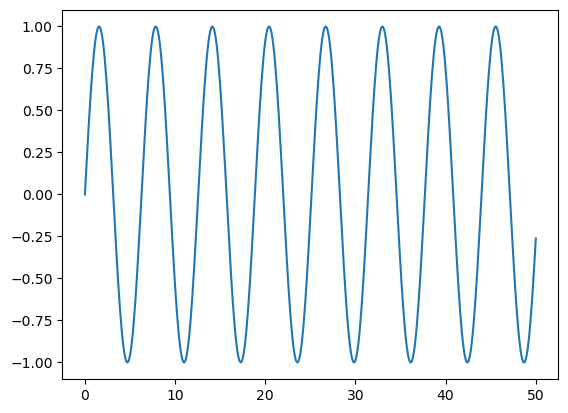

In [44]:
plt.plot(x, y)

In [45]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [46]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [47]:
test_percent = 0.1
test_point = np.round(len(df)*test_percent)
test_point

50.0

In [48]:
test_idx = int(len(df) - test_point)
test_idx

451

In [49]:
train = df.iloc[:test_idx]
test = df.iloc[test_idx:]

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [52]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(data=train_scaled, targets=train_scaled, length=length, batch_size=batch_size)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [55]:
n_features = 1

In [56]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_9991/3367823435.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5)


401/401 [==============================] - 2s 3ms/step - loss: 0.0031
Epoch 2/5
401/401 [==============================] - 1s 3ms/step - loss: 5.2490e-05
Epoch 3/5
401/401 [==============================] - 1s 3ms/step - loss: 4.2029e-04
Epoch 4/5
401/401 [==============================] - 1s 3ms/step - loss: 1.7139e-04
Epoch 5/5
401/401 [==============================] - 1s 3ms/step - loss: 6.6875e-05


In [59]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

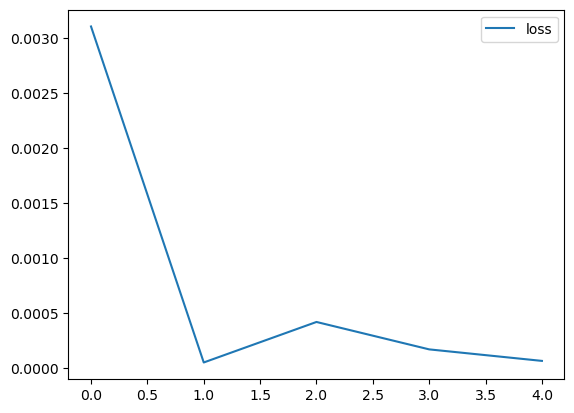

In [60]:
losses.plot()

In [61]:
first_eval_batch = train_scaled[-length:]

In [62]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [63]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 69ms/step


array([[0.9495093]], dtype=float32)

In [64]:
test_scaled[0]

array([0.94955134])

In [81]:
test_pred = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for _ in range(len(test)):
    pred = model.predict(current_batch)
    test_pred.append(pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [pred], axis=1)

1/1 [==============================] - 0s 11ms/step


In [91]:
#test_pred

In [83]:
test['Predictions'] = scaler.inverse_transform(test_pred)

/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_9991/1685265195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = scaler.inverse_transform(test_pred)


<AxesSubplot:>

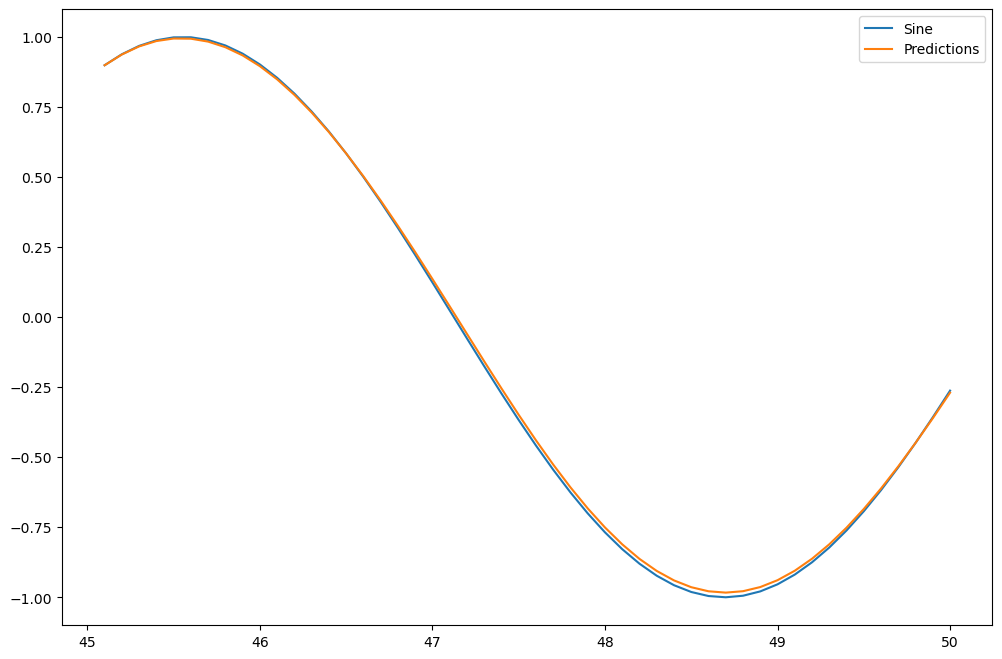

In [86]:
test.plot(figsize=(12,8))

# LSTM

Add Early Stopping and Validation Generator

In [87]:
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [89]:
test_scaled.shape

(50, 1)

In [90]:
length = 49

generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=1)

In [92]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [93]:
model.fit_generator(generator=generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_9991/3346774569.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])


402/402 [==============================] - 4s 8ms/step - loss: 0.0207 - val_loss: 9.2445e-05
Epoch 2/20
402/402 [==============================] - 3s 7ms/step - loss: 2.7130e-04 - val_loss: 8.8240e-04
Epoch 3/20
402/402 [==============================] - 3s 7ms/step - loss: 1.5433e-04 - val_loss: 1.0028e-04


In [94]:
test_pred = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for _ in range(len(test)):
    pred = model.predict(current_batch, verbose=0)
    test_pred.append(pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [pred], axis=1)

/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_9991/594766484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = scaler.inverse_transform(test_pred)


<AxesSubplot:>

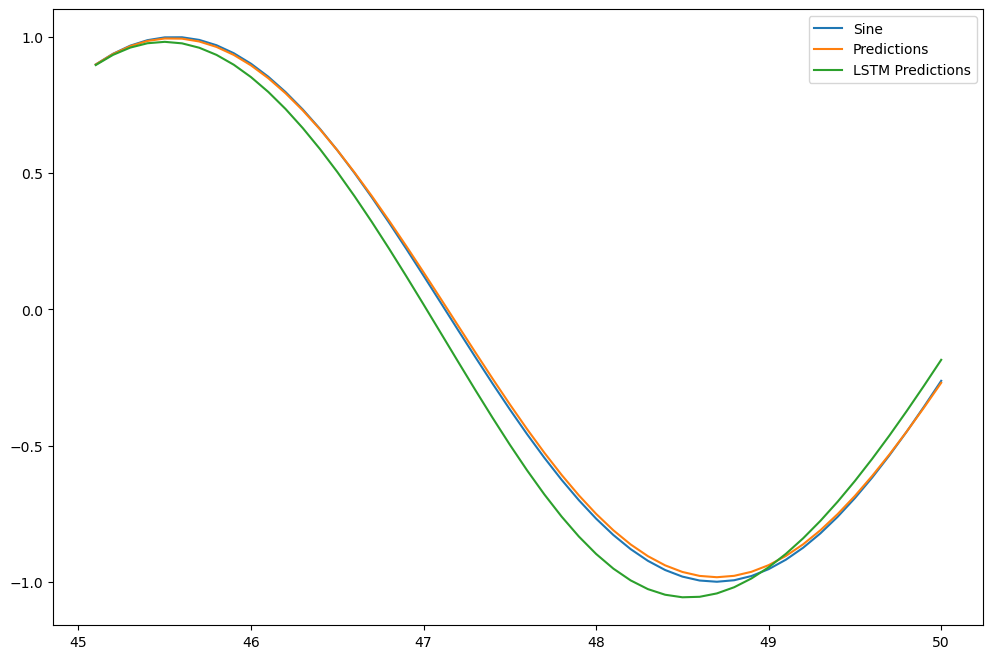

In [98]:
test['LSTM Predictions'] = scaler.inverse_transform(test_pred)
test.plot(figsize=(12,8))

# Forecasting

Let's forecast into unknown range by using all the data

In [99]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [100]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [101]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_9991/2968077443.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


452/452 [==============================] - 4s 7ms/step - loss: 0.0129
Epoch 2/6
452/452 [==============================] - 3s 7ms/step - loss: 1.2290e-04
Epoch 3/6
452/452 [==============================] - 3s 7ms/step - loss: 3.0384e-04
Epoch 4/6
452/452 [==============================] - 3s 7ms/step - loss: 1.6938e-04
Epoch 5/6
452/452 [==============================] - 3s 7ms/step - loss: 1.2523e-04
Epoch 6/6
452/452 [==============================] - 3s 7ms/step - loss: 2.8006e-04


In [108]:
forecast = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for _ in range(50):
    pred = model.predict(current_batch, verbose=0)
    forecast.append(pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [pred], axis=1)

In [109]:
forecast = full_scaler.inverse_transform(forecast)

In [118]:
forecast_idx = np.arange(start=50.1, stop=50.1+len(forecast)*0.1, step=0.1)

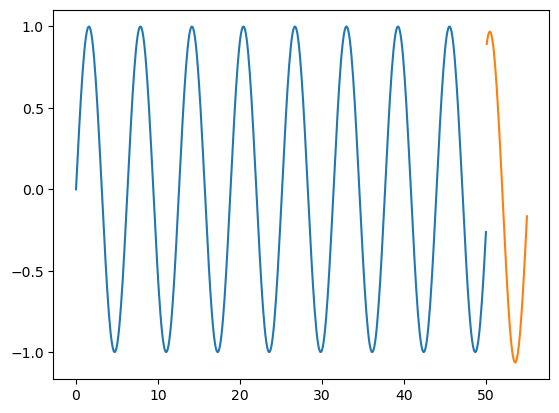

In [120]:
plt.plot(df)
plt.plot(forecast_idx, forecast)